In [1]:
pip install nashpy

In [21]:
import nashpy as nash
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import fsolve
from numpy.linalg import eig

# Parameters
c = 1 # cost of attack
d = 1 # cost of defence
m = 0 # probability of catching attacker for unsuccessful attack
n = 0 # probability of catching attacker for successful attack
w = 5 # Loss to the defender
r = 10 # Ratio of attack benefit to the defender's loss
v = 0 # probability of successful defence

a = (1 / r) * w # benefit of attack
b = w # benefit of defence
p = 0
s = 0

# Payoff matrices based on the given parameters
payoff_defender = np.array([
        [ 0, -w],
        [-d+b, -d + v*b - w*(1 - v)],
    ])
payoff_attacker = np.array([
        [ 0, 0],
        [-c+a - m* p, -c+a*(1-v) - v * n * s - (1-v) *m * p],
    ])

prisoners_dilemma = nash.Game(payoff_defender, payoff_attacker)
prisoners_dilemma

Bi matrix game with payoff matrices:

Row player:
[[ 0 -5]
 [ 4 -6]]

Column player:
[[ 0.   0. ]
 [-0.5 -0.5]]

In [22]:
# Define the replicator dynamics equations
def F_beta(beta, alpha):
    return beta * (1 - beta) * (b - d - b*alpha + v*b*alpha + v*w*alpha)

def F_alpha(alpha, beta):
    return alpha * (1 - alpha) * (-c + a - m*p - a*v*beta - v*n*s*beta + v*m*p*beta)

# Jacobian matrix to determine stability
def jacobian(beta, alpha):
    # Partial derivative of F_beta with respect to alpha
    dF_beta_dalpha = beta * (1 - beta) * (-b + v*b + v*w)

    # Partial derivative of F_alpha with respect to beta
    dF_alpha_dbeta = alpha * (1 - alpha) * (-a*v - v*n*s + v*m*p)

    # Partial derivative of F_beta with respect to beta
    dF_beta_dbeta = (1 - 2 * beta) * (b - d - b*alpha + v*b*alpha + v*w*alpha)
                    #+ \(1 - 2 * beta) * beta * (1 - beta)

    # Partial derivative of F_alpha with respect to alpha
    dF_alpha_dalpha = (1 - 2 * alpha) * (-c + a - m*p - a*v*beta - v*n*s*beta + v*m*p*beta)
                      #+ \(1 - 2 * alpha) * alpha * (1 - alpha)

    # Return the 2x2 Jacobian matrix
    #return np.array([[dF_alpha_dalpha, dF_alpha_dbeta],
      #               [dF_beta_dalpha, dF_beta_dbeta]])

    return np.array([[dF_beta_dbeta, dF_beta_dalpha],
                     [dF_alpha_dbeta, dF_alpha_dalpha]])

# Example values for alpha and beta
alpha = 0
beta = 1

# Call the jacobian function and print the result
J = jacobian(beta, alpha)
print("Jacobian matrix:")
print(J)


Jacobian matrix:
[[-4.   0. ]
 [ 0.  -0.5]]


In [23]:
# Function to find equilibrium points by solving the system F_alpha = 0, F_beta = 0
def equilibrium_points(guess):
    def equations(p):
        alpha, beta = p
        return (F_beta(beta, alpha), F_alpha(alpha, beta))
    return fsolve(equations, guess)

# Get equilibrium points with a rough guess
equilibria = equilibrium_points([0, 1])

alpha_eq, beta_eq = equilibria
print(f"Equilibrium point: beta = {beta_eq}, alpha = {alpha_eq}")

# Compute the Jacobian matrix at the equilibrium point
J = jacobian(beta_eq, alpha_eq)
print(f"Jacobian matrix at equilibrium:\n{J}")

Equilibrium point: beta = 1.0, alpha = 0.0
Jacobian matrix at equilibrium:
[[-4.  -0. ]
 [ 0.  -0.5]]


Eigenvalues: [-4.  -0.5]
Stability: Stable


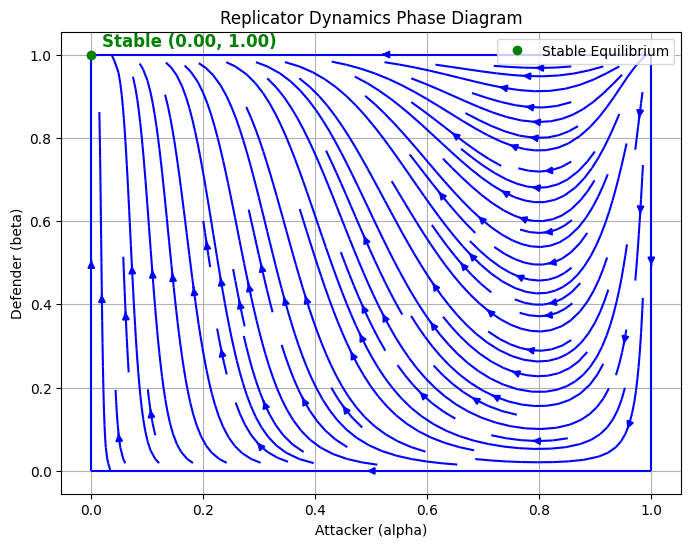

In [24]:
# Calculate eigenvalues to determine stability
eigenvalues = eig(J)[0]
print(f"Eigenvalues: {eigenvalues}")

# Stability classification based on eigenvalues
if np.all(np.real(eigenvalues) < 0):
    stability = "Stable"
    color = 'green'
elif np.all(np.real(eigenvalues) > 0):
    stability = "Unstable"
    color = 'red'
else:
    stability = "Saddle"
    color = 'orange'

print(f"Stability: {stability}")

# Plot the phase diagram and equilibrium points
alpha_vals = np.linspace(0, 1, 100)
beta_vals = np.linspace(0, 1, 100)
alpha_grid, beta_grid = np.meshgrid(alpha_vals, beta_vals)

F_alpha_vals = F_alpha(alpha_grid, beta_grid)
F_beta_vals = F_beta(beta_grid, alpha_grid)

plt.figure(figsize=(8, 6))
plt.streamplot(alpha_vals, beta_vals, F_alpha_vals, F_beta_vals, color='blue', density=1.2)

# Plot the equilibrium point
plt.plot(alpha_eq, beta_eq, 'o', color=color, label=f'{stability} Equilibrium')

# Label the equilibrium point on the graph
plt.text(alpha_eq + 0.02, beta_eq + 0.02, f'{stability} ({alpha_eq:.2f}, {beta_eq:.2f})',
         color=color, fontsize=12, weight='bold')

# Labels and legend
plt.xlabel('Attacker (alpha)')
plt.ylabel('Defender (beta)')
plt.title('Replicator Dynamics Phase Diagram')

# Adding a legend to distinguish stable, unstable, and saddle points
plt.legend()

# Show the plot
plt.grid(True)
plt.show()

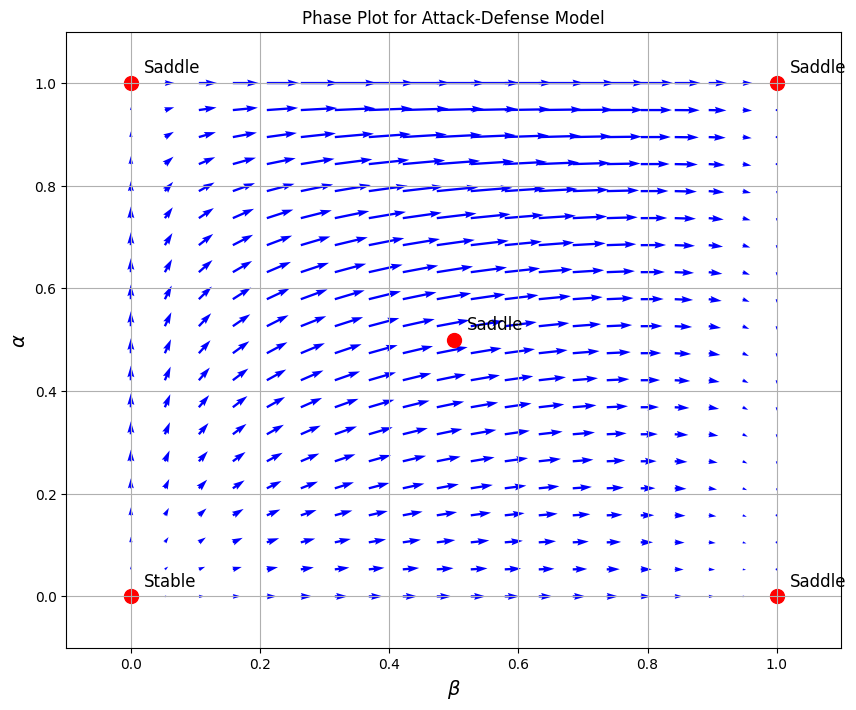

In [27]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint
from numpy.linalg import eig

# Define parameters
c = 1  # cost of attack
d = 1  # cost of defence
m = 0  # probability of catching attacker for unsuccessful attack
n = 0  # probability of catching attacker for successful attack
w = 5  # Loss to the defender
r = 1  # Ratio of attack benefit to the defender's loss
v = 1  # probability of successful defence
p = 0
s = 0

# Derived parameters
a = (1 / r) * w  # benefit of attack
b = w  # benefit of defence

# System of equations
def f(alpha, beta):
    return -d + b - b*alpha + v*b*alpha - alpha + v*w*alpha + w*alpha

def g(alpha, beta):
    return -c + a - m*p - a*v*beta - v*n*s*beta + v*m*p*beta

# Equilibrium points
equilibrium_points = [(0, 0), (0, 1), (1, 0), (1, 1), (0.5, 0.5)]

# Define the system of ODEs for the attack-defense model
def system(y, t):
    beta, alpha = y
    dBeta_dt = beta * (1 - beta) * f(alpha, beta)
    dAlpha_dt = alpha * (1 - alpha) * g(alpha, beta)
    return [dBeta_dt, dAlpha_dt]

# Compute the Jacobian matrix
def jacobian(alpha, beta):
    df_dalpha = np.array([[-b*(1-beta)*(1-2*alpha), 0],
                          [0, -a*(1-alpha)*(1-2*beta)]])
    return df_dalpha

# Compute eigenvalues for the Jacobian at each equilibrium point
def eigenvalues_at_eq(eq):
    beta, alpha = eq
    jacobian_matrix = jacobian(alpha, beta)
    eigenvals, _ = eig(jacobian_matrix)
    return eigenvals

# Evaluate eigenvalues for all equilibrium points
eigenvalues = [eigenvalues_at_eq(eq) for eq in equilibrium_points]

# Determine stability type based on eigenvalues
def stability_type(eigenvals):
    if all(np.real(eigenvals) < 0):
        return "Stable"
    elif all(np.real(eigenvals) > 0):
        return "Unstable"
    else:
        return "Saddle"

# Determine stability of all equilibrium points
stabilities = [stability_type(evals) for evals in eigenvalues]

# Phase plot for the system using quivers
def phase_plot():
    beta_vals = np.linspace(0, 1, 20)
    alpha_vals = np.linspace(0, 1, 20)
    B, A = np.meshgrid(beta_vals, alpha_vals)
    dBdt = B * (1 - B) * f(A, B)
    dAdt = A * (1 - A) * g(A, B)

    plt.figure(figsize=(10, 8))
    plt.quiver(B, A, dBdt, dAdt, color='blue')
    plt.xlabel(r'$\beta$', fontsize=14)
    plt.ylabel(r'$\alpha$', fontsize=14)
    plt.title("Phase Plot for Attack-Defense Model")

    # Mark equilibrium points and their stability types
    for i, eq in enumerate(equilibrium_points):
        plt.scatter(eq[0], eq[1], color='red', s=100)
        plt.text(eq[0] + 0.02, eq[1] + 0.02, f'{stabilities[i]}', fontsize=12)

    plt.xlim([-0.1, 1.1])
    plt.ylim([-0.1, 1.1])
    plt.grid(True)
    plt.show()

# Plot the line graph for the stability of eigenvalues
def stability_line_plot():
    eq_labels = ['(0,0)', '(0,1)', '(1,0)', '(1,1)', '(0.5,0.5)']

    plt.figure(figsize=(10, 6))

    for i, eigenvals in enumerate(eigenvalues):
        real_parts = [np.real(ev) for ev in eigenvals]
        plt.plot([eq_labels[i]]*len(eigenvals), real_parts, 'ro-', label=f'Equilibrium {eq_labels[i]}' if i == 0 else "")

    plt.xlabel('Equilibrium Points', fontsize=14)
    plt.ylabel('Real Part of Eigenvalues', fontsize=14)
    plt.title("Stability of Equilibrium Points (Eigenvalue Real Parts)")
    plt.axhline(0, color='black', linewidth=1, linestyle='--')
    plt.grid(True)
    plt.legend()
    plt.show()

# Call the functions
phase_plot()  # Draw phase plot


In [8]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import eig

# Define the parameters
c = 1   # cost of attack
d = 1   # cost of defence
m = 0 # probability of catching attacker for unsuccessful attack
n = 0   # probability of catching attacker for successful attack
w = 5  # Loss to the defender
r = 10 # Ratio of attack benefit to the defender's loss
v = 0   # probability of successful defence
p = 0
s = 0

# Derived parameters
a = (1 / r) * w  # benefit of attack
b = w           # benefit of defence

# Payoff matrices based on the given parameters
payoff_defender = np.array([
        [ 0, -w],
        [-d+b, -d + v*b - w*(1 - v)],
    ])
payoff_attacker = np.array([
        [ 0, 0],
        [-c+a - m* p, -c+a*(1-v) - v * n * s - (1-v) *m * p],
    ])
print("Payoff defender:")
print(payoff_defender)

print("Payoff attacker:")
print(payoff_attacker)

Payoff defender:
[[ 0 -5]
 [ 4 -6]]
Payoff attacker:
[[ 0.   0. ]
 [-0.5 -0.5]]


In [10]:
# prompt: find replicator dynamics for above payoff matrices

def replicator_dynamics(payoff_matrix):

  # Calculate the average payoff
  avg_payoff = np.dot(payoff_matrix.T, np.array([1, 1])) / 2

  # Calculate the replicator dynamics
  replicator_dynamics = np.array([
      [
          (payoff_matrix[0, 0] - avg_payoff[0]),
          (payoff_matrix[0, 1] - avg_payoff[0])
      ],
      [
          (payoff_matrix[1, 0] - avg_payoff[1]),
          (payoff_matrix[1, 1] - avg_payoff[1])
      ]
  ])

  return replicator_dynamics

# Calculate the replicator dynamics for the attacker and defender
replicator_dynamics_defender = replicator_dynamics(payoff_defender)
replicator_dynamics_attacker = replicator_dynamics(payoff_attacker)

print("Replicator Dynamics for Defender:")
print(replicator_dynamics_defender)

print("Replicator Dynamics for Attacker:")
print(replicator_dynamics_attacker)


Replicator Dynamics for Defender:
[[-2.  -7. ]
 [ 9.5 -0.5]]
Replicator Dynamics for Attacker:
[[ 0.25  0.25]
 [-0.25 -0.25]]


In [11]:
# Define the system of differential equations
def system(t, z, payoff_defender, payoff_attacker):
    x, y = z

    # Payoffs for defender strategies
    f_no_defence = payoff_defender[0][0] * (1 - y) + payoff_defender[0][1] * y
    f_defence = payoff_defender[1][0] * (1 - y) + payoff_defender[1][1] * y

    # Payoffs for attacker strategies
    g_no_attack = payoff_attacker[0][0] * (1 - x) + payoff_attacker[0][1] * x
    g_attack = payoff_attacker[1][0] * (1 - x) + payoff_attacker[1][1] * x

    # Average payoffs
    f_avg = x * f_defence + (1 - x) * f_no_defence
    g_avg = y * g_attack + (1 - y) * g_no_attack

    # Replicator dynamics
    dxdt = x * (1 - x) * (f_defence - f_no_defence)
    dydt = y * (1 - y) * (g_attack - g_no_attack)

    return [dxdt, dydt]



In [15]:
# prompt: find jacobian matrix for above

import numpy as np

def jacobian(x, y, payoff_defender, payoff_attacker):

    # Payoffs for defender strategies
    f_no_defence = payoff_defender[0][0] * (1 - y) + payoff_defender[0][1] * y
    f_defence = payoff_defender[1][0] * (1 - y) + payoff_defender[1][1] * y

    # Payoffs for attacker strategies
    g_no_attack = payoff_attacker[0][0] * (1 - x) + payoff_attacker[0][1] * x
    g_attack = payoff_attacker[1][0] * (1 - x) + payoff_attacker[1][1] * x

    # Calculate the Jacobian matrix
    dfdx = (1 - 2 * x) * (f_defence - f_no_defence)
    dfdy = -x * (1 - x) * (payoff_defender[1][0] - payoff_defender[1][1] - payoff_defender[0][0] + payoff_defender[0][1])

    dgdx = -y * (1 - y) * (payoff_attacker[1][0] - payoff_attacker[1][1] - payoff_attacker[0][0] + payoff_attacker[0][1])
    dgdy = (1 - 2 * y) * (g_attack - g_no_attack)

    jacobian_matrix = np.array([
        [dfdx, dfdy],
        [dgdx, dgdy]
    ])

    return jacobian_matrix

# Example values for x and y
x = 0
y = 0

# Calculate the Jacobian matrix
jac = jacobian(x, y, payoff_defender, payoff_attacker)

# Display the Jacobian matrix
print("Jacobian Matrix:")
print(jac)

Jacobian Matrix:
[[ 4.   0. ]
 [ 0.  -0.5]]


In [16]:
# Equilibrium points
equilibrium_points = [(0, 0), (0, 1), (1, 0), (1, 1), (1/2, 1/2)]

# Calculate eigenvalues for each equilibrium point
for x, y in equilibrium_points:
  jac = jacobian(x, y, payoff_defender, payoff_attacker)
  w, v = eig(jac)
  print(f"Eigenvalues for equilibrium point ({x}, {y}):")
  print(w)


Eigenvalues for equilibrium point (0, 0):
[ 4. +0.j -0.5+0.j]
Eigenvalues for equilibrium point (0, 1):
[-1. +0.j  0.5+0.j]
Eigenvalues for equilibrium point (1, 0):
[-4. +0.j -0.5+0.j]
Eigenvalues for equilibrium point (1, 1):
[1. +0.j 0.5+0.j]
Eigenvalues for equilibrium point (0.5, 0.5):
[0.+0.j 0.+0.j]


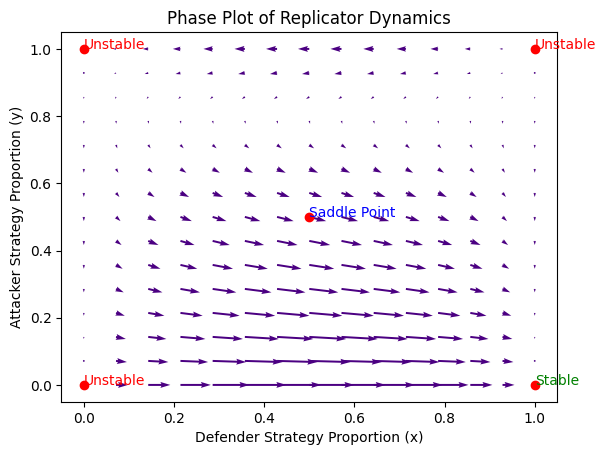

In [17]:
# prompt: plot phase plot for the eigen values to show evolutionary stability

import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint
from scipy.linalg import eig

# Define the grid for the phase plot
x = np.linspace(0, 1, 15)
y = np.linspace(0, 1, 15)
X, Y = np.meshgrid(x, y)

# Calculate the derivatives at each point on the grid
U = np.zeros_like(X)
V = np.zeros_like(Y)
for i in range(len(x)):
  for j in range(len(y)):
    dxdt, dydt = system(0, [x[i], y[j]], payoff_defender, payoff_attacker)
    U[j, i] = dxdt
    V[j, i] = dydt

# Plot the phase plot
fig, ax = plt.subplots()
ax.quiver(X, Y, U, V, angles='xy', scale_units='xy', scale=10, color='indigo')
ax.set_xlabel("Defender Strategy Proportion (x)")
ax.set_ylabel("Attacker Strategy Proportion (y)")
ax.set_title("Phase Plot of Replicator Dynamics")

# Add labels for equilibrium points
for x, y in equilibrium_points:
  ax.plot(x, y, 'ro')
  jac = jacobian(x, y, payoff_defender, payoff_attacker)
  w, v = eig(jac)
  if all(np.real(w) < 0):
    ax.text(x, y, "Stable", color='green')
  elif any(np.real(w) > 0):
    ax.text(x, y, "Unstable", color='red')
  else:
    ax.text(x, y, "Saddle Point", color='blue')

plt.show()
